In [23]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation, ToPILImage
import torchvision.transforms.functional as TF
from torchvision.datasets import ImageFolder
import random
from matplotlib import pyplot as plt
from random import randint

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# load images

root_dir = 'data/img/'

# check inception restriction of image size
target_size = (299, 299)

transforms = Compose([
    Resize(target_size),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

images = ImageFolder(root_dir, transform=transforms)

In [24]:
list_category_img = pd.read_csv('list_category_img.txt', sep="\t", header=0)
list_category_img.columns = ["image_name", "category_label"]

list_category_cloth = pd.read_csv('list_category_cloth.txt', sep="\t", header=0)
list_category_cloth.columns = ["category_name", "category_type"]

list_eval_partition = pd.read_csv('list_eval_partition.txt', sep="\t", header=0)
list_eval_partition.columns = ["image_name", "evaluation_status"]

In [25]:
list_category_img.head()

,image_name,category_label
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


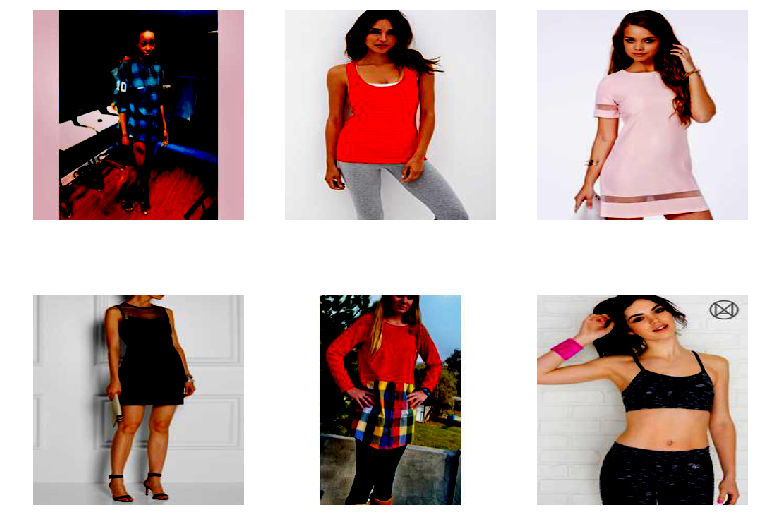

In [26]:
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(images))
    axes[i].imshow(images[index][0].permute(1, 2, 0))
    axes[i].axis('off')

In [27]:
from train import train

import torchvision.models as models
import torch.nn as nn

# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5

inception = models.inception_v3(pretrained=True)

inception = inception.to(device)

inception_trained = train(inception, loss_fn, optim, sched, eps, trainloader_augmented, valloader_augmented)

Epoch 1/5



IndexError: index 1 is out of bounds for dimension 1 with size 1

In [15]:
import torchvision.models as models
import torch.nn as nn

# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5

inception = models.inception_v3(pretrained=True)

inception = inception.to(device)

inception_trained = train(inception, loss_fn, optim, sched, eps, trainloader_augmented, valloader_augmented)

Epoch 1/5


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [ ]:
# Transform given images for fashion classification (without rotation)

def my_classification_transforms(image):
    image = TF.to_pil_image(image)
    image = TF.resize(image, 32, interpolation=2)
    image = TF.to_tensor(image)
    image = TF.normalize(image, (0.5, ), (0.5, ))

    return image

In [ ]:
# create Dataset for fashion classification (with fashion labels)

class FashionMNISTClassificationDataset(Dataset):

    def __init__(self, data, target, transform):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        datapoint = self.transform(self.data[index])
        targetpoint = self.target[index]

        return datapoint, targetpoint

In [ ]:
# dataloader for classification -> take only a subset

batch_size=1

# generate random indices for a 10% subset
number_trainInst = int(len(trainset))
subset_indices = np.random.choice(number_trainInst, number_trainInst/10, replace=False)
subset_data = torch.zeros([number_trainInst/10, 28, 28], dtype=torch.float)
subset_targets = np.zeros(number_trainInst/10, dtype=long)
# create subset for 10% of the original training set
for i, index in enumerate(subset_indices):
    subset_data[i] = trainset.data[index]
    subset_targets[i] = trainset.targets[index]

n_train = int(len(subset_data) * 0.8)

train_augmented_classification = FashionMNISTClassificationDataset(
    data=subset_data[:n_train], 
    # use next line only because of performance issues
#     data=subset_data[:50], 
    target=subset_targets[:n_train], 
    # use next line only because of performance issues
#     target=subset_targets[:50], 
    transform=my_classification_transforms)

trainloader_classification = DataLoader(train_augmented_classification, batch_size=batch_size, shuffle=True, num_workers=32)

val_augmented_classification = FashionMNISTClassificationDataset(
    data=subset_data[n_train:], 
    # use next line only because of performance issues
#     data=subset_data[100:150],
    target=subset_targets[n_train:], 
    # use next line only because of performance issues
#     target=subset_targets[100:150], 
    transform=my_classification_transforms)

valloader_classification = DataLoader(val_augmented_classification, batch_size=batch_size, shuffle=True, num_workers=32)

test_augmented_classification = FashionMNISTClassificationDataset(
    data=testset.data, 
    target=testset.targets, 
    transform=my_classification_transforms)

testloader_classification = DataLoader(test_augmented_classification, batch_size=batch_size, shuffle=True, num_workers=32)

In [ ]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# freeze all layers of the trained model
for param in resnet20_trained.parameters():
    param.requires_grad = False

# # unfreeze layer3
# for param in resnet20_trained.layer3.parameters():
#     param.requires_grad = True

# unfreeze final fc layer
for param in resnet20_trained.fc.parameters():
    param.requires_grad = True

# replace fc layer with 10 outputs
resnet20_trained.fc = nn.Linear(64, 10)

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20_trained.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5

resnet20_trained = resnet20_trained.to(device)

resnet20_trainedClassification = train(resnet20_trained, loss_fn, optim, sched, eps, trainloader_classification, valloader_classification)

In [ ]:
import matplotlib.pyplot as plt

# summarize the results graphically

def stats_plot(trainLoss, valLoss, valAccuracy):
    # x axis is number of epochs
    x = np.arange(0, len(valLoss), 1)

    fig=plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.figure(1)

    plt.subplot(221)
    plt.ylabel('training loss', fontsize=14, color='black')
    plt.grid(True)
    plt.plot(x, trainLoss, 'b', linewidth=2)


    plt.subplot(223)
    plt.ylabel('validation loss', fontsize=14, color='black')
    plt.plot(x, valLoss, 'r', linewidth=2)
    plt.grid(True)
    plt.xlabel('epoches', fontsize=14, color='black')


    plt.subplot(122)
    plt.ylabel('validation accuracy', fontsize=14, color='black')
    plt.plot(x, valAccuracy, 'g', linewidth=3)
    #plt.hlines(y=46.5, color='orange', label = '46.4%% threshold')
    plt.grid(True)
    plt.xlabel('epoches', fontsize=14, color='black')

    plt.tight_layout()

    plt.show()